
<h1><font color="#00586D" size=5>ETL Orchestration in a Datalake</font></h1>

## NobelPrice

In this project I work with Nobel prize celebrations data and the laureate people and entities. For this I will use the [nobelprize.org](https://www.nobelprize.org/about/developer-zone-2/) API. This API has documentation in OpenAPI format hosted on the [swaggerhub](https://app.swaggerhub.com/apis/NobelMedia/NobelMasterData/2.1) platform, which is a fairly widespread standard.

I create a datalake using **AWS S3**, implement ETLs on **AWS Lambda**, and orchestrate its execution via **Prefect**, running the flow locally.


### Description

The Nobel prizes are celebrated annually (barring some problems, as it happened during _the second world war_). Data extraction is automated every **January 1 of each year** by doing the following:
- Download data **from the previous year for all categories** (`che`, `eco`, `lit`, `pea`, `phy`, `med`)
- Storage in the datalake (prefix `raw`) of this data in parquet format
- Execution of the implemented ETL (bronze and silver)

Finally, the jupyter notebook is used to access the tables generated by the ETL and **answer certain analytics questions**.

## Create the S3 bucket that will be our datalake

An S3 bucket is created in our on AWS. This bucket will contain the prefixes:

- **raw**: will contain the raw data extracted from the API.
- **bronze**: will contain tables that will be join tables with possibly changed column names and casted column types.
- **silver**: will contain high-level tables that will be used to access information granularly.

## Create the layer for AWS Lambda

I use `pandas`, `pyarrow`, `requests` and `s3fs` in all of our lambdas. The console has a limit of 50MB per zip, but our layer is higher. In order to create it you have to upload the zip `layer.zip` to an S3 bucket and create the layer from the S3 URI. The layer is created for `python 3.8` and `x86_64` architecture.

**NOTE**: see the versions of the packages used in the layers for lambda in the `requirements_lambda.txt` file. You have to use the same version of python and the packages to develop locally to avoid errors.

## Create the AWS Pull Lambdas

The functions extract information from `nobelPrizes` and `laureates`, that is, Nobel prizes and laureates or laureates. For it:

1. The `http://api.nobelprize.org/2.1/nobelPrize/{category}/{year}` endpoint is used to obtain the information of all the Nobel prizes for a specific category and year.
2. The `http://api.nobelprize.org/2.1/laureate/{laureateID}` endpoint is used to get the information of a laureate based on their ID.

The data is stored in the datalake in parquet format, which allows you to comfortably read several files with a `pd.read_parquet` call and you can run data compaction processes when necessary. However, there are certain complex structures that parquet does not have implemented in its python version. Therefore, instead of storing the raw data directly, it is lightly processed in order to generate structured data. It is important to note that this is done **to simplify the process**, since it is important to store the raw data, as it is extracted, for later use. A more realistic practice would be to store the json as-is as raw, and use a lambda to create a raw_processed which would be the parquet that is now generated.

**Important**: select `x86_64` architecture and python version 3.8. Set the lambda timeout to 1 minute and 2048 MB of RAM to ensure it has time to run properly.

### AWS Lambda `extractNobelPrizes`

The function must receive in the event the category and the year to extract and make use of the `http://api.nobelprize.org/2.1/nobelPrize/{category}/{year}` endpoint to extract the information. Once fetched, a single-row pandas DataFrame is constructed (manually from a python structure). This dataframe will have the following columns:

- **awardYear**: the `awardYear` field. If it does not exist, leave a NA
- **category**: the `en` field inside `category`. If it does not exist, leave a NA
- **categoryFullName**: the `en` field within `categoryFullName`. If it does not exist, leave a NA
- **dateAwarded**: the `dateAwarded` field. If it does not exist, leave a NA
- **prizeAmount**: the `prizeAmount` field. If it does not exist, leave a NA
- **prizeAmountAdjusted**: the `prizeAmountAdjusted` field. If it does not exist, leave a NA
- **laureates_id**: a list of laureate id's, corresponding to the `id` field of each element of the `laureates` list
- **laureates_portion**: a list of strings corresponding to the internal `portion` value of each element of the `laureates` list

Subsequently, the DataFrame is stored in the datalake bucket in parquet format (with the name `raw/nobelPrizes/{category}-{year}.parquet`).

In addition, the function must **return a list containing the IDs of the laureates** involved in the Nobel prizes obtained (list of id's from the `laureates` column).

In [62]:
import numpy as np
import pandas as pd
import fastparquet
import requests
import botocore
import aiobotocore
import fsspec
import s3fs

BUCKET_DATALAKE = "your_bucket"

def lambda_handler(event, context):
    category = event['category']
    year = event['year']
    url = f'http://api.nobelprize.org/2.1/nobelPrize/{category}/{year}'
    response = requests.get(url).json()
    if 'awardYear' in response[0]:
        df =(pd.json_normalize(response).loc[:, ['awardYear', 'category.en', 'categoryFullName.en', 'dateAwarded', 'prizeAmount', 'prizeAmountAdjusted', 'laureates']]
             .rename(columns={'category.en': 'category', 'categoryFullName.en': 'categoryFullName'}).fillna(value=pd.NA))
        df[['laureates_id', 'laureates_portion']] = df['laureates'].apply(lambda x: pd.Series({'laureates_id': [d['id'] for d in x], 'laureates_portion': [d['portion'] for d in x]}))
        df = df.drop('laureates', axis=1)
        df.to_parquet(f"{BUCKET_DATALAKE}/raw/nobelPrizes/{category}-{year}.parquet", index=False)
        return df["laureates_id"].tolist()

In [2]:
import numpy as np
import pandas as pd
import fastparquet
import requests
import botocore
import aiobotocore
import fsspec
import s3fs


category = "che"
year = 2010
url = f'http://api.nobelprize.org/2.1/nobelPrize/{category}/{year}'
response = requests.get(url).json()
if 'awardYear' in response[0]:
    df =(pd.json_normalize(response).loc[:, ['awardYear', 'category.en', 'categoryFullName.en', 'dateAwarded', 'prizeAmount', 'prizeAmountAdjusted', 'laureates']]
            .rename(columns={'category.en': 'category', 'categoryFullName.en': 'categoryFullName'}).fillna(value=pd.NA))
    df[['laureates_id', 'laureates_portion']] = df['laureates'].apply(lambda x: pd.Series({'laureates_id': [d['id'] for d in x], 'laureates_portion': [d['portion'] for d in x]}))
    df = df.drop('laureates', axis=1)
df.head(5)

,awardYear,category,categoryFullName,dateAwarded,prizeAmount,prizeAmountAdjusted,laureates_id,laureates_portion
0,2010,Chemistry,The Nobel Prize in Chemistry,2010-10-06,10000000,11015580,"[851, 852, 853]","[1/3, 1/3, 1/3]"


### AWS Lambda `extractLaureate`

The function must receive in the event the ID of the laureate to extract and make use of the `http://api.nobelprize.org/2.1/laureate/{laureateID}` endpoint to extract the information. Once fetched, a single-row pandas DataFrame is constructed (manually from a python structure). This dataframe will have the following columns:

- **id**: the `id` field. If it does not exist, leave a NA
- **fullName**: the `en` field within `fullName`. If it does not exist, leave a NA
- **fileName**: the `fileName` field. If it does not exist, leave a NA
- **gender**: the `gender` field. If it does not exist, leave a NA
- **birth**: the `date` field inside `birth`. If it does not exist, leave a NA

Subsequently, the DataFrame is stored in the datalake bucket in parquet format (with the name `raw/laureates/{laureateID}.parquet`).


**Important**: select `x86_64` architecture and python version 3.8. Also set the lambda timeout to 1 minute and 2048 MB of RAM to make sure it has time to run correctly.

In [3]:
import numpy as np
import pandas as pd
import fastparquet
import requests
import botocore
import aiobotocore
import fsspec
import s3fs

BUCKET_DATALAKE = "your_bucket"

def lambda_handler(event, context):
    laureateID = event['laureateID']
    url = f'http://api.nobelprize.org/2.1/laureate/{laureateID}'
    response = requests.get(url).json()
    if 'id' in response[0]:
        df =pd.json_normalize(response).loc[:, ['id', 'fullName.en', 'fileName', 'gender', 'birth.date']].fillna(value=pd.NA).rename(columns={'fullName.en': 'fullName', 'birth.date': 'birth'})
        df.to_parquet(f"{BUCKET_DATALAKE}/raw/laureates/{laureateID}.parquet", index=False)

## Combination of Nobel laureates and laureates

Since the data in `raw/nobelPrizes` and `raw/laureates` are parquet files, we can read them all at once and create a single `pd.DataFrame` using `pd.read_parquet("s3://{bucket-datalake}/ raw/nobelPrizes")` and `pd.read_parquet("s3://{bucket-datalake}/raw/laureates")` respectively.

Two AWS Lambda functions are implemented below to generate a `bronze` table and a `silver` table.

**NOTE**: To develop the code of these two ETLs locally, the files `nobelPrizes-1901-2019.parquet` and `laureates-1901-2019.parquet` have been used, which contain the data exported from 1901 to 2019 ( using the API endpoints that give all existing paginated data). But the lambda should eventually read directly from the S3 bucket. Hereafter I will refer to the nobel prizes data as `df_nobel_prizes` and the laureates data as `df_laureates`.

## ETL bronze

In this ETL, the raw data in front of us is analyzed, cleaned, restructured, and combined.

### Process the `df_nobel_prizes` dataframe

1. The content of the dataframe and the completeness of the data are explored. Missing values are discarded.
2. The same award can be shared by several laureates, this is indicated by the `laureates_id` and `laureates_portion` columns, which are lists. [explode](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html) is used to transform the dataframe to have only one exploder per row.
3. Cast the `laureates_id` column to be an integer value

### Process the `df_laureates` dataframe

4. It is detected that some of the columns of interest do not have a consistent name. Columns are renamed:
     - `fileName` to `file_name`
5. Cast the `id` column to be an integer value

### Merge both dataframes

6. Combine both dataframes by means of the laureate id column. Use an inner join.

### Deploy the AWS Lambda running the ETL bronze

7. The lambda should generate in the datalake a parquet file resulting from writing the pandas dataframe (path `bronze/bronze_laureates.parquet`).
8. As before, use the layer. Select `x86_64` architecture and python version 3.8. Set the lambda timeout to 5 minutes and 2048 MB of RAM to ensure it has time to run properly.


In [153]:
import numpy as np
import pandas as pd
import fastparquet
import requests
import botocore
import aiobotocore
import fsspec
import s3fs

BUCKET_DATALAKE = "your_bucket"

def lambda_handler(event, context):
    df_nobel_prizes = pd.read_parquet(f"{BUCKET_DATALAKE}/raw/nobelPrizes")
    df_nobel_prizes = df_nobel_prizes.dropna(subset=["laureates_id"])
    df_nobel_prizes = df_nobel_prizes.explode(["laureates_id", "laureates_portion"])
    df_nobel_prizes["laureates_id"] = df_nobel_prizes["laureates_id"].astype(int)

    df_laureates = pd.read_parquet(f"{BUCKET_DATALAKE}/raw/laureates")
    df_laureates = df_laureates.rename(columns={'fileName': 'file_name'})
    df_laureates["id"] = df_laureates["id"].astype(int)
    df_laureates = df_laureates.drop_duplicates(subset=['id'])

    df_merged = pd.merge(df_nobel_prizes, df_laureates, left_on="laureates_id", right_on="id", how="inner").drop('id', axis=1)
    df_merged.to_parquet(f"{BUCKET_DATALAKE}/bronze/bronze_laureates.parquet", index=False)

## ETL silver

In this ETL I am going to process the bronze dataframe `df_bronze_laureates` and build new variables.

### Process the `df_bronze_laureates` dataframe


1. After analyzing the bronze dataframe, the name of the columns is evaluated and some of them do not have a consistent name. Columns are renamed to have a uniform format:
     - `prizeAmount` times `prize_amount`
     - `awardYear` for `year`
     - `fileName` to `file_name`
     - `laureates_id` by `laureate_id`df_nobel_prizes = (df_nobel_prizes
                 .rename(columns={'prizeAmount': 'prize_amount', 'awardYear': 'year', 'fileName': 'file_name',
                                  'laureates_id': 'laureate_id', 'laureates_portion': 'laureate_portion', 'categoryFullName': 'category_full_name',
                                  'dateAwarded': 'date_awarded', 'prizeAmountAdjusted': 'prize_amount_adjusted', 'fullName': 'full_name'}))
     - `laureates_portion` by `laureate_portion`
     - `categoryFullName` to `category_full_name`
     - `dateAwarded` by `date_awarded`
     - `prizeAmountAdjusted` port `prize_amount_adjusted`
     - `fullName` to `full_name`
 
2. One of the columns created above, `laureate_portion`, is a string that represents a fraction. It is interesting to have the value in numerical format to create a new `prize_amount_real` column that represents the real prize received by each laureate (when distributing the prize, it is economically divided based on `laureate_portion`). Two more columns are created:

   - `laureate_portion`: This column, which is a fraction in string format, is overwritten to be a decimal number. Use the code `from fractions import Fraction`, and cast a `float` of the `Fraction(text)` to convert it to a numeric value

   - `prize_amount_real`: This column represents the real value earned by each prize winner. Calculated as `prize_amount` multiplied by `laureate_portion`
  
### Deploy the AWS Lambda running the silver ETL

3. The lambda must generate in the datalake a parquet file resulting from writing the pandas dataframe (path `silver/silver_laureates.parquet`).
4. As before, use the layer. Select `x86_64` architecture and python version 3.8. The lambda timeout is also set to 5 minutes and 2048 MB of RAM to ensure it has time to run properly.

In [5]:
import numpy as np
import pandas as pd
import fastparquet
import requests
import botocore
import aiobotocore
import fsspec
import s3fs
from fractions import Fraction

BUCKET_DATALAKE = "your_bucket"

def lambda_handler(event, context):
    df_bronze_laureates = pd.read_parquet(f"{BUCKET_DATALAKE}/bronze/bronze_laureates.parquet")
    df_bronze_laureates = (df_bronze_laureates
                    .rename(columns={'prizeAmount': 'prize_amount', 'awardYear': 'year', 'fileName': 'file_name', 
                                     'laureates_id': 'laureate_id', 'laureates_portion': 'laureate_portion', 'categoryFullName': 'category_full_name', 
                                     'dateAwarded': 'date_awarded', 'prizeAmountAdjusted': 'prize_amount_adjusted', 'fullName': 'full_name'}))
    df_bronze_laureates['laureate_portion'] = df_bronze_laureates['laureate_portion'].apply(lambda x: float(Fraction(x)))
    df_bronze_laureates['prize_amount_real'] = df_bronze_laureates['prize_amount'] * df_bronze_laureates['laureate_portion']
    df_bronze_laureates.to_parquet(f"{BUCKET_DATALAKE}/silver/silver_laureates.parquet", index=False)

## Orchestration with Prefect core

Now I am going to develop a flow with prefect so that:

1. Export the previous year's data by calling the `extractNobelPrizes` lambda with a parameter indicating the category to export (`che`, `eco`, `lit`, `pea`, `phy`, or `med`). That is, 6 invocations will be made, one per category. To get the previous year, get the current date (`prefect.runtime.flow_run.scheduled_start_time.year`) from the context, which is a `pendulum.datetime.DateTime` object, access the `year` field and subtract 1 from that .
2. For each invocation of the `extractNobelPrizes` lambda, make `N` invocations of the `extractNobelPrizeate` lambda, using the `map` functionality so that for each laureate id returned by the `extractNobelPrizeates` lambda (list of prize ids), laureates ) the `extractLaureate` lambda is executed with the corresponding `laureateId` parameter.
3. After pulling all the data from the previous year, the bronze ETL (lambda `bronze_laureates`) should now be run.
4. Finally, the bronze ETL (lambda `bronze_laureates`) should be run.

**Note**: boto3 is used to invoke AWS Lambda. Documentation at this [link](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/lambda.html#Lambda.Client.invoke).

In [58]:
import boto3
import os

aws_access_key_id="your_key_id"
aws_secret_access_key="you_access_key"
aws_session_token="your_token"


lambda_client = boto3.client(
    'lambda',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    aws_session_token= aws_session_token,
    region_name = "us-east-1"
)

#os.environ["PREFECT__RUNTIME__FLOW_RUN__SCHEDULED_START_TIME"] = "2023-01-01 00:00:00"
#del os.environ["PREFECT__RUNTIME__FLOW_RUN__SCHEDULED_START_TIME"]

In [57]:
import pendulum
from prefect import task, flow
import datetime
import prefect.runtime
import boto3
import ast
import os
import time


@task(retries=3, retry_delay_seconds=5)
def extract_nobel_prizes(category):
    if isinstance(prefect.runtime.flow_run.scheduled_start_time, str):
        year = pendulum.from_format(prefect.runtime.flow_run.scheduled_start_time, "YYYY-MM-DD HH:mm:ss").year
    else:
        year = prefect.runtime.flow_run.scheduled_start_time.year
    response = lambda_client.invoke(
        FunctionName="extractNobelPrizes",
        InvocationType="RequestResponse",
        Payload = f'{{"category": "{category}", "year": "{year-1}"}}'.encode()
    )
    result = response["Payload"].read().decode()
    nobel_list = ast.literal_eval(result)
    print(f">>>>>>>>>>>>>>>Finished nobel_prizes with {category} and {year}")
    return nobel_list[0]


@task(retries=3, retry_delay_seconds=5)
def extract_laureate(laureate_id):
    response = lambda_client.invoke(
        FunctionName="extractLaureate",
        InvocationType="RequestResponse",
        Payload=f'{{"laureateID": "{laureate_id}"}}'.encode(),
    )
    print(f">>>>>>>>>>>>>>>Finished laureate_id {laureate_id}")

@task(retries=3, retry_delay_seconds=5)
def bronze_laureates():
    response = lambda_client.invoke(
        FunctionName="bronze",
        InvocationType="RequestResponse",
        Payload=b'{}',
    )
    print(f">>>>>>>>>>>>>>>Finished bronze")

@task(retries=3, retry_delay_seconds=5)
def silver_laureates():
    response = lambda_client.invoke(
        FunctionName="silver",
        InvocationType="RequestResponse",
        Payload=b'{}',
    )
    print(f">>>>>>>>>>>>>>>Finished silver")

@flow (log_prints=True)
def etl_nobel():
    category_list = ["che", "eco", "lit", "pea", "phy", "med"]
    for category in category_list:
        nobel_task = extract_nobel_prizes(category)
        laureate_task = extract_laureate.map(nobel_task)
    for task in laureate_task:
        task.wait()
    bronze_task = bronze_laureates.submit()
    silver_task = silver_laureates.submit(wait_for=[bronze_task])

In [171]:
etl_nobel()

10:32:34.804 | INFO    | prefect.engine - Created flow run 'swinging-boa' for flow 'etl-nobel'

10:32:35.041 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_nobel_prizes-0' for task 'extract_nobel_prizes'

10:32:35.044 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_nobel_prizes-0' for execution.

10:32:35.852 | INFO    | Task run 'extract_nobel_prizes-0' - >>>>>>>>>>>>>>>Finished nobel_prizes with che and 2021

10:32:35.926 | INFO    | Task run 'extract_nobel_prizes-0' - Finished in state Completed()

10:32:36.029 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-0' for task 'extract_laureate'

10:32:36.032 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-0' for execution.

10:32:36.067 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_nobel_prizes-1' for task 'extract_nobel_prizes'

10:32:36.070 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_nobel_prizes-1' for execution.

10:32:36.137 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-1' for task 'extract_laureate'

10:32:36.142 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-1' for execution.

10:32:36.585 | INFO    | Task run 'extract_laureate-0' - >>>>>>>>>>>>>>>Finished laureate_id 991

10:32:36.654 | INFO    | Task run 'extract_laureate-0' - Finished in state Completed()

10:32:36.981 | INFO    | Task run 'extract_laureate-1' - >>>>>>>>>>>>>>>Finished laureate_id 992

10:32:37.023 | INFO    | Task run 'extract_nobel_prizes-1' - >>>>>>>>>>>>>>>Finished nobel_prizes with eco and 2021

10:32:37.088 | INFO    | Task run 'extract_laureate-1' - Finished in state Completed()

10:32:37.149 | INFO    | Task run 'extract_nobel_prizes-1' - Finished in state Completed()

10:32:37.223 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-2' for task 'extract_laureate'

10:32:37.226 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-2' for execution.

10:32:37.261 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_nobel_prizes-2' for task 'extract_nobel_prizes'

10:32:37.264 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_nobel_prizes-2' for execution.

10:32:37.327 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-3' for task 'extract_laureate'

10:32:37.330 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-3' for execution.

10:32:37.727 | INFO    | Task run 'extract_laureate-2' - >>>>>>>>>>>>>>>Finished laureate_id 995

10:32:37.796 | INFO    | Task run 'extract_laureate-2' - Finished in state Completed()

10:32:38.145 | INFO    | Task run 'extract_nobel_prizes-2' - >>>>>>>>>>>>>>>Finished nobel_prizes with lit and 2021

10:32:38.162 | INFO    | Task run 'extract_laureate-3' - >>>>>>>>>>>>>>>Finished laureate_id 996

10:32:38.232 | INFO    | Task run 'extract_nobel_prizes-2' - Finished in state Completed()

10:32:38.298 | INFO    | Task run 'extract_laureate-3' - Finished in state Completed()

10:32:38.325 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-4' for task 'extract_laureate'

10:32:38.332 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-4' for execution.

10:32:38.369 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_nobel_prizes-3' for task 'extract_nobel_prizes'

10:32:38.372 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_nobel_prizes-3' for execution.

10:32:38.787 | INFO    | Task run 'extract_laureate-4' - >>>>>>>>>>>>>>>Finished laureate_id 993

10:32:38.862 | INFO    | Task run 'extract_laureate-4' - Finished in state Completed()

10:32:39.149 | INFO    | Task run 'extract_nobel_prizes-3' - >>>>>>>>>>>>>>>Finished nobel_prizes with pea and 2021

10:32:39.226 | INFO    | Task run 'extract_nobel_prizes-3' - Finished in state Completed()

10:32:39.283 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-5' for task 'extract_laureate'

10:32:39.286 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-5' for execution.

10:32:39.319 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_nobel_prizes-4' for task 'extract_nobel_prizes'

10:32:39.323 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_nobel_prizes-4' for execution.

10:32:39.670 | INFO    | Task run 'extract_laureate-5' - >>>>>>>>>>>>>>>Finished laureate_id 994

10:32:39.752 | INFO    | Task run 'extract_laureate-5' - Finished in state Completed()

10:32:40.136 | INFO    | Task run 'extract_nobel_prizes-4' - >>>>>>>>>>>>>>>Finished nobel_prizes with phy and 2021

10:32:40.217 | INFO    | Task run 'extract_nobel_prizes-4' - Finished in state Completed()

10:32:40.295 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-6' for task 'extract_laureate'

10:32:40.298 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-6' for execution.

10:32:40.336 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-7' for task 'extract_laureate'

10:32:40.340 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-7' for execution.

10:32:40.397 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-8' for task 'extract_laureate'

10:32:40.400 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-8' for execution.

10:32:40.481 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_nobel_prizes-5' for task 'extract_nobel_prizes'

10:32:40.484 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_nobel_prizes-5' for execution.

10:32:40.892 | INFO    | Task run 'extract_laureate-6' - >>>>>>>>>>>>>>>Finished laureate_id 988

10:32:40.971 | INFO    | Task run 'extract_laureate-6' - Finished in state Completed()

10:32:41.327 | INFO    | Task run 'extract_laureate-7' - >>>>>>>>>>>>>>>Finished laureate_id 989

10:32:41.394 | INFO    | Task run 'extract_laureate-7' - Finished in state Completed()

10:32:41.397 | INFO    | Task run 'extract_nobel_prizes-5' - >>>>>>>>>>>>>>>Finished nobel_prizes with med and 2021

10:32:41.410 | INFO    | Task run 'extract_laureate-8' - >>>>>>>>>>>>>>>Finished laureate_id 990

10:32:41.480 | INFO    | Task run 'extract_nobel_prizes-5' - Finished in state Completed()

10:32:41.550 | INFO    | Task run 'extract_laureate-8' - Finished in state Completed()

10:32:41.570 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-10' for task 'extract_laureate'

10:32:41.574 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-10' for execution.

10:32:41.608 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-11' for task 'extract_laureate'

10:32:41.613 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-11' for execution.

10:32:41.671 | INFO    | Flow run 'swinging-boa' - Created task run 'extract_laureate-9' for task 'extract_laureate'

10:32:41.675 | INFO    | Flow run 'swinging-boa' - Submitted task run 'extract_laureate-9' for execution.

10:32:42.055 | INFO    | Task run 'extract_laureate-10' - >>>>>>>>>>>>>>>Finished laureate_id 986

10:32:42.121 | INFO    | Task run 'extract_laureate-10' - Finished in state Completed()

10:32:42.479 | INFO    | Task run 'extract_laureate-9' - >>>>>>>>>>>>>>>Finished laureate_id 985

10:32:42.488 | INFO    | Task run 'extract_laureate-11' - >>>>>>>>>>>>>>>Finished laureate_id 987

10:32:42.571 | INFO    | Task run 'extract_laureate-9' - Finished in state Completed()

10:32:42.611 | INFO    | Task run 'extract_laureate-11' - Finished in state Completed()

10:32:42.669 | INFO    | Flow run 'swinging-boa' - Created task run 'bronze_laureates-0' for task 'bronze_laureates'

10:32:42.673 | INFO    | Flow run 'swinging-boa' - Submitted task run 'bronze_laureates-0' for execution.

10:32:42.749 | INFO    | Flow run 'swinging-boa' - Created task run 'silver_laureates-0' for task 'silver_laureates'

10:32:42.753 | INFO    | Flow run 'swinging-boa' - Submitted task run 'silver_laureates-0' for execution.

10:32:44.224 | INFO    | Task run 'bronze_laureates-0' - >>>>>>>>>>>>>>>Finished bronze

10:32:44.289 | INFO    | Task run 'bronze_laureates-0' - Finished in state Completed()

10:32:45.155 | INFO    | Task run 'silver_laureates-0' - >>>>>>>>>>>>>>>Finished silver

10:32:45.237 | INFO    | Task run 'silver_laureates-0' - Finished in state Completed()

10:32:45.311 | INFO    | Flow run 'swinging-boa' - Finished in state Completed('All states completed.')

[Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpers

## Backfill

The ideal way to export all data from 1901 to date is not to run the flow for each year simulating its normal year-to-year run, as that would involve a lot of API calls and would be a very slow and expensive process. The ideal is to make use of the API endpoints to obtain all the data in blocks and do this process of capturing the data in blocks only once, and from there the flow would be in charge of updating the data year by year, as well as executing the corresponding ETLs.

The files `nobelPrizes-1901-2019.parquet` and `laureates-1901-2019.parquet` (in the `data.zip` file) contain the data exported from 1901 to 2019 using the API endpoints that return all the data existing paginated. Going to:

1. Make sure the datalake bucket is empty. Delete all files generated by previous executions.
2. Upload the files `nobelPrizes-1901-2019.parquet` and `laureates-1901-2019.parquet` to the datalake bucket to the prefixes `raw/nobelPrizes` and `raw/laureates` respectively.
3. Run the flow manually pretending that it is January 1 from the year 2021 to the current year using the environment variable described above (`2021-01-01`, `2022-01-01`, ...).

In [59]:
os.environ["PREFECT__RUNTIME__FLOW_RUN__SCHEDULED_START_TIME"] = "2023-01-01 00:00:00"
etl_nobel()

08:05:15.417 | INFO    | prefect.engine - Created flow run 'nano-tiger' for flow 'etl-nobel'

08:05:15.763 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_nobel_prizes-0' for task 'extract_nobel_prizes'

08:05:15.768 | INFO    | Flow run 'nano-tiger' - Executing 'extract_nobel_prizes-0' immediately...

08:05:20.068 | INFO    | Task run 'extract_nobel_prizes-0' - >>>>>>>>>>>>>>>Finished nobel_prizes with che and 2023

08:05:20.172 | INFO    | Task run 'extract_nobel_prizes-0' - Finished in state Completed()

08:05:20.299 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-0' for task 'extract_laureate'

08:05:20.302 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-0' for execution.

08:05:20.332 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-2' for task 'extract_laureate'

08:05:20.335 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-2' for execution.

08:05:20.393 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_nobel_prizes-1' for task 'extract_nobel_prizes'

08:05:20.396 | INFO    | Flow run 'nano-tiger' - Executing 'extract_nobel_prizes-1' immediately...

08:05:20.458 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-1' for task 'extract_laureate'

08:05:20.461 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-1' for execution.

08:05:21.874 | INFO    | Task run 'extract_nobel_prizes-1' - >>>>>>>>>>>>>>>Finished nobel_prizes with eco and 2023

08:05:21.943 | INFO    | Task run 'extract_nobel_prizes-1' - Finished in state Completed()

08:05:22.085 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-3' for task 'extract_laureate'

08:05:22.093 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-3' for execution.

08:05:22.126 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-4' for task 'extract_laureate'

08:05:22.129 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-4' for execution.

08:05:22.195 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-5' for task 'extract_laureate'

08:05:22.198 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-5' for execution.

08:05:22.289 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_nobel_prizes-2' for task 'extract_nobel_prizes'

08:05:22.292 | INFO    | Flow run 'nano-tiger' - Executing 'extract_nobel_prizes-2' immediately...

08:05:23.256 | INFO    | Task run 'extract_nobel_prizes-2' - >>>>>>>>>>>>>>>Finished nobel_prizes with lit and 2023

08:05:23.331 | INFO    | Task run 'extract_nobel_prizes-2' - Finished in state Completed()

08:05:23.388 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-6' for task 'extract_laureate'

08:05:23.391 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-6' for execution.

08:05:23.425 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_nobel_prizes-3' for task 'extract_nobel_prizes'

08:05:23.427 | INFO    | Flow run 'nano-tiger' - Executing 'extract_nobel_prizes-3' immediately...

08:05:23.935 | INFO    | Task run 'extract_laureate-0' - >>>>>>>>>>>>>>>Finished laureate_id 1015

08:05:24.006 | INFO    | Task run 'extract_laureate-2' - >>>>>>>>>>>>>>>Finished laureate_id 743

08:05:24.012 | INFO    | Task run 'extract_laureate-0' - Finished in state Completed()

08:05:24.075 | INFO    | Task run 'extract_laureate-2' - Finished in state Completed()

08:05:24.604 | INFO    | Task run 'extract_laureate-1' - >>>>>>>>>>>>>>>Finished laureate_id 1016

08:05:24.609 | INFO    | Task run 'extract_nobel_prizes-3' - >>>>>>>>>>>>>>>Finished nobel_prizes with pea and 2023

08:05:24.678 | INFO    | Task run 'extract_laureate-1' - Finished in state Completed()

08:05:24.719 | INFO    | Task run 'extract_nobel_prizes-3' - Finished in state Completed()

08:05:24.803 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-8' for task 'extract_laureate'

08:05:24.806 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-8' for execution.

08:05:24.835 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-7' for task 'extract_laureate'

08:05:24.838 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-7' for execution.

08:05:24.889 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_nobel_prizes-4' for task 'extract_nobel_prizes'

08:05:24.892 | INFO    | Flow run 'nano-tiger' - Executing 'extract_nobel_prizes-4' immediately...

08:05:24.958 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-9' for task 'extract_laureate'

08:05:24.961 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-9' for execution.

08:05:25.363 | INFO    | Task run 'extract_laureate-8' - >>>>>>>>>>>>>>>Finished laureate_id 1019

08:05:25.424 | INFO    | Task run 'extract_laureate-8' - Finished in state Completed()

08:05:25.848 | INFO    | Task run 'extract_laureate-7' - >>>>>>>>>>>>>>>Finished laureate_id 1018

08:05:25.861 | INFO    | Task run 'extract_laureate-9' - >>>>>>>>>>>>>>>Finished laureate_id 1020

08:05:25.946 | INFO    | Task run 'extract_laureate-5' - >>>>>>>>>>>>>>>Finished laureate_id 1023

08:05:25.987 | INFO    | Task run 'extract_laureate-9' - Finished in state Completed()

08:05:26.023 | INFO    | Task run 'extract_laureate-5' - Finished in state Completed()

08:05:26.068 | INFO    | Task run 'extract_laureate-7' - Finished in state Completed()

08:05:26.071 | INFO    | Task run 'extract_laureate-3' - >>>>>>>>>>>>>>>Finished laureate_id 1021

08:05:26.134 | INFO    | Task run 'extract_laureate-3' - Finished in state Completed()

08:05:26.200 | INFO    | Task run 'extract_laureate-4' - >>>>>>>>>>>>>>>Finished laureate_id 1022

08:05:26.277 | INFO    | Task run 'extract_laureate-4' - Finished in state Completed()

08:05:26.318 | INFO    | Task run 'extract_nobel_prizes-4' - >>>>>>>>>>>>>>>Finished nobel_prizes with phy and 2023

08:05:26.379 | INFO    | Task run 'extract_nobel_prizes-4' - Finished in state Completed()

08:05:26.474 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-11' for task 'extract_laureate'

08:05:26.478 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-11' for execution.

08:05:26.496 | INFO    | Task run 'extract_laureate-6' - >>>>>>>>>>>>>>>Finished laureate_id 1017

08:05:26.535 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-10' for task 'extract_laureate'

08:05:26.539 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-10' for execution.

08:05:26.627 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_nobel_prizes-5' for task 'extract_nobel_prizes'

08:05:26.631 | INFO    | Flow run 'nano-tiger' - Executing 'extract_nobel_prizes-5' immediately...

08:05:26.747 | INFO    | Task run 'extract_laureate-6' - Finished in state Completed()

08:05:26.951 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-12' for task 'extract_laureate'

08:05:26.961 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-12' for execution.

08:05:27.758 | INFO    | Task run 'extract_laureate-11' - >>>>>>>>>>>>>>>Finished laureate_id 1013

08:05:27.839 | INFO    | Task run 'extract_laureate-11' - Finished in state Completed()

08:05:27.857 | INFO    | Task run 'extract_laureate-10' - >>>>>>>>>>>>>>>Finished laureate_id 1012

08:05:27.923 | INFO    | Task run 'extract_laureate-10' - Finished in state Completed()

08:05:27.987 | INFO    | Task run 'extract_nobel_prizes-5' - >>>>>>>>>>>>>>>Finished nobel_prizes with med and 2023

08:05:28.060 | INFO    | Task run 'extract_nobel_prizes-5' - Finished in state Completed()

08:05:28.107 | INFO    | Task run 'extract_laureate-12' - >>>>>>>>>>>>>>>Finished laureate_id 1014

08:05:28.134 | INFO    | Flow run 'nano-tiger' - Created task run 'extract_laureate-13' for task 'extract_laureate'

08:05:28.137 | INFO    | Flow run 'nano-tiger' - Submitted task run 'extract_laureate-13' for execution.

08:05:28.190 | INFO    | Task run 'extract_laureate-12' - Finished in state Completed()

08:05:29.076 | INFO    | Task run 'extract_laureate-13' - >>>>>>>>>>>>>>>Finished laureate_id 1011

08:05:29.156 | INFO    | Task run 'extract_laureate-13' - Finished in state Completed()

08:05:29.208 | INFO    | Flow run 'nano-tiger' - Created task run 'bronze_laureates-0' for task 'bronze_laureates'

08:05:29.212 | INFO    | Flow run 'nano-tiger' - Submitted task run 'bronze_laureates-0' for execution.

08:05:29.278 | INFO    | Flow run 'nano-tiger' - Created task run 'silver_laureates-0' for task 'silver_laureates'

08:05:29.280 | INFO    | Flow run 'nano-tiger' - Submitted task run 'silver_laureates-0' for execution.

08:05:35.273 | INFO    | Task run 'bronze_laureates-0' - >>>>>>>>>>>>>>>Finished bronze

08:05:35.354 | INFO    | Task run 'bronze_laureates-0' - Finished in state Completed()

08:05:39.195 | INFO    | Task run 'silver_laureates-0' - >>>>>>>>>>>>>>>Finished silver

08:05:39.268 | INFO    | Task run 'silver_laureates-0' - Finished in state Completed()

08:05:39.354 | INFO    | Flow run 'nano-tiger' - Finished in state Completed('All states completed.')

[Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpers


## Data Analytics

You have a very valuable data set. We are going to read locally with pandas using `pd.read_parquet("s3://{bucket-datalake}/silver/silver_laureates.parquet")` and we are going to answer the following questions to gain insight about the data we are driving.

1. Who is the laureate who has received the most? (in case of a tie, give the oldest)
2. Generate a line graph showing the total investment per year (sum of `prize_amount_real`). What has been the trend?
3. Is there any laureate who has received more than two awards? Show the top 5.
4. Which category has received the most awards? And what more money has he given?

In [60]:
import io
s3_client = boto3.client(
        's3', 
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
        aws_session_token=aws_session_token
    )

In [144]:
s3_obj = s3_client.get_object(Bucket="mcidaen3.capstone13.nobel.data.ivan", Key= "silver/silver_laureates.parquet")
s3_obj_bytes = s3_obj['Body'].read()
df_silver_laureates = fastparquet.ParquetFile(io.BytesIO(s3_obj_bytes)).to_pandas()

QUESTION 1:
The oldest laureate who has collected the most is 817, Doris Lessing.
Code below.

In [132]:
#Group by laureate_id and sum and order by prize_amount_real. It looks a draw.
df_silver_laureates.groupby('laureate_id')[["prize_amount_real"]].sum(numeric_only=True).sort_values('prize_amount_real', ascending=False)

,prize_amount_real
laureate_id,
832,10000000.00
854,10000000.00
845,10000000.00
844,10000000.00
993,10000000.00
...,...
344,36528.75
343,36528.75
5,35339.50


In [133]:
#The oldest one.
df_silver_laureates["prize_amount_real_sum"] = df_silver_laureates.groupby('laureate_id')["prize_amount_real"].transform("sum")

In [134]:
df_silver_laureates[df_silver_laureates["prize_amount_real_sum"]==10000000].sort_values('birth', ascending=True).head(5)

,year,category,category_full_name,date_awarded,prize_amount,prize_amount_adjusted,laureate_id,laureate_portion,full_name,file_name,gender,birth,prize_amount_real,prize_amount_real_sum
820,2007,Literature,The Nobel Prize in Literature,2007-10-11,10000000,11506932,817,1.0,Doris Lessing,lessing,female,1919-10-22,10000000.0,10000000.0
764,2002,Peace,The Nobel Peace Prize,2002-10-11,10000000,12252888,762,1.0,James Earl Carter,carter,male,1924-10-01,10000000.0,10000000.0
863,2010,Physiology or Medicine,The Nobel Prize in Physiology or Medicine,None,10000000,11015580,848,1.0,Robert G. Edwards,edwards,male,1925-09-27,10000000.0,10000000.0
763,2002,Literature,The Nobel Prize in Literature,2002-10-10,10000000,12252888,761,1.0,Imre Kertész,kertesz,male,1929-11-09,10000000.0,10000000.0
799,2005,Literature,The Nobel Prize in Literature,2005-10-13,10000000,11923798,801,1.0,Harold Pinter,pinter,male,1930-10-10,10000000.0,10000000.0


In [137]:
#Showing all fields for laureate 817
df_silver_laureates[df_silver_laureates["laureate_id"]==817]

,year,category,category_full_name,date_awarded,prize_amount,prize_amount_adjusted,laureate_id,laureate_portion,full_name,file_name,gender,birth,prize_amount_real,prize_amount_real_sum
820,2007,Literature,The Nobel Prize in Literature,2007-10-11,10000000,11506932,817,1.0,Doris Lessing,lessing,female,1919-10-22,10000000.0,10000000.0


QUESTION 2: Until the year 70 more or less it was stagnant. Then it has an increasing trend until 2000. From 2000 it remains constant until 2011.
From 2011 until now it has had several ups and downs.

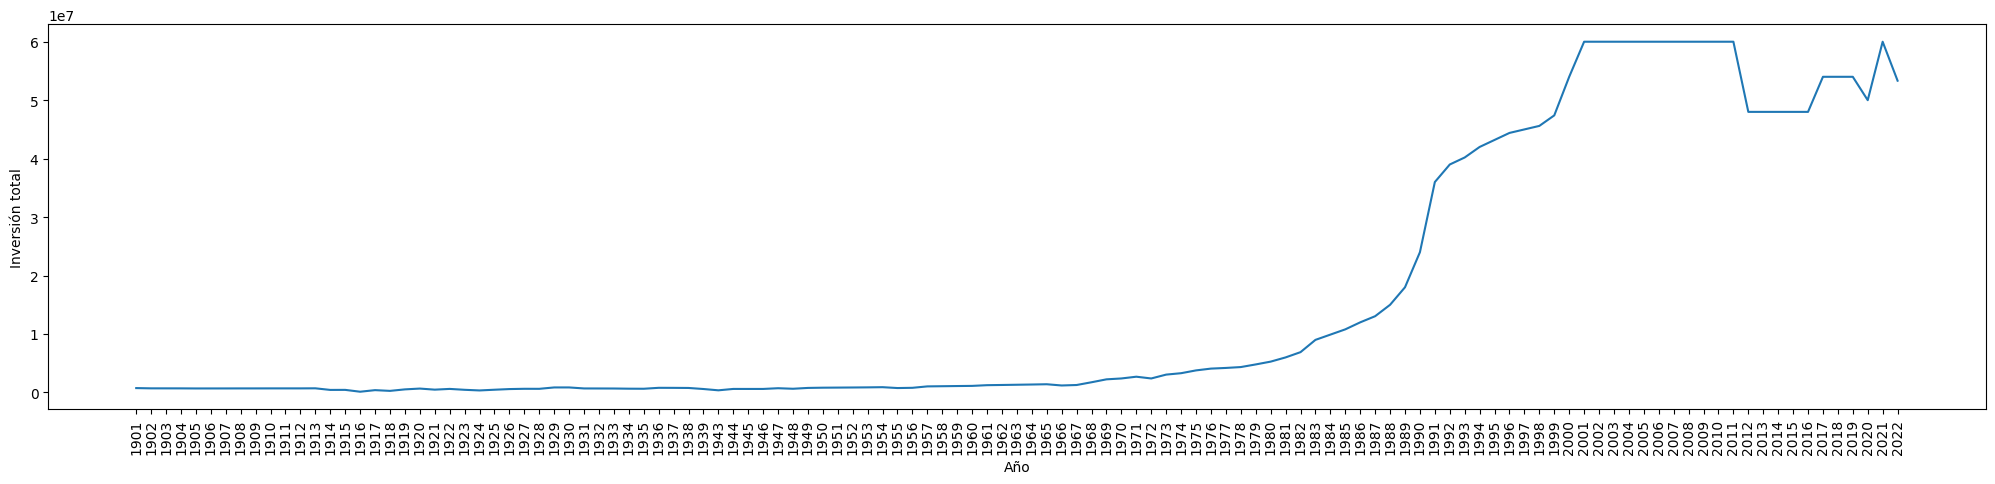

In [138]:
import matplotlib.pyplot as plt
df_year_grouped = df_silver_laureates.groupby('year').sum(numeric_only=True).sort_values('year', ascending=True).reset_index()

plt.figure(figsize=(25,5))
plt.plot(df_year_grouped['year'], df_year_grouped['prize_amount_real'])
plt.xlabel('Año')
plt.xticks(rotation=90)
plt.ylabel('Inversión total')
plt.show()

QUESTION 3: Yes, there is one with more than 2 prizes, 482.

In [ ]:
#Showing the 5 with more prizes
df_silver_laureates['laureate_id'].value_counts().head(5)

In [140]:
#Showing the info
df_silver_laureates[df_silver_laureates['laureate_id'].isin(df_silver_laureates['laureate_id'].value_counts().head(5).index)]

,year,category,category_full_name,date_awarded,prize_amount,prize_amount_adjusted,laureate_id,laureate_portion,full_name,file_name,gender,birth,prize_amount_real,prize_amount_real_sum
6,2022,Chemistry,The Nobel Prize in Chemistry,2022-10-05,10000000,10000000,743,0.333333,K. Barry Sharpless,sharpless,male,1941-04-28,3.333333e+06,8.333333e+06
7,2001,Chemistry,The Nobel Prize in Chemistry,2001-10-10,10000000,12518033,743,0.500000,K. Barry Sharpless,sharpless,male,1941-04-28,5.000000e+06,8.333333e+06
114,1917,Peace,The Nobel Peace Prize,1917-12-10,133823,3991689,482,1.000000,None,red-cross,None,None,1.338230e+05,3.881640e+05
115,1944,Peace,The Nobel Peace Prize,1945-11-12,121841,2555983,482,1.000000,None,red-cross,None,None,1.218410e+05,3.881640e+05
116,1963,Peace,The Nobel Peace Prize,1963-10-10,265000,2890771,482,0.500000,None,red-cross,None,None,1.325000e+05,3.881640e+05
304,1954,Chemistry,The Nobel Prize in Chemistry,None,181647,2688094,217,1.000000,Linus Carl Pauling,pauling,male,1901-02-28,1.816470e+05,4.388670e+05
305,1962,Peace,The Nobel Peace Prize,1963-10-10,257220,2888429,217,1.000000,Linus Carl Pauling,pauling,male,1901-02-28,2.572200e+05,4.388670e+05
307,1954,Peace,The Nobel Peace Prize,1955-11-05,181647,2688094,515,1.000000,None,refugees,None,None,1.816470e+05,1.181647e+06
308,1981,Peace,The Nobel Peace Prize,1981-10-14,1000000,2982813,515,1.000000,None,refugees,None,None,1.000000e+06,1.181647e+06
335,1958,Chemistry,The Nobel Prize in Chemistry,None,214559,2694692,222,1.000000,Frederick Sanger,sanger,male,1918-08-13,2.145590e+05,4.345590e+05


QUESTION 4: If the rows of awards distributed among various people each year are grouped together, the category that has received the most awards has been "Physics" with 116 awards.
The one that has delivered the most money has also been "Physics".

In [152]:
#The first 5 categories that have received the most awards are shown
df_silver_laureates.groupby("category").agg(
    number_shared_nobel=("category", "size"),
    unique_nobel=("year", "nunique")
).sort_values('unique_nobel', ascending=False).reset_index()

,category,number_shared_nobel,unique_nobel
0,Physics,222,116
1,Literature,119,115
2,Chemistry,191,114
3,Physiology or Medicine,225,113
4,Peace,137,102
5,Economic Sciences,92,54


In [116]:
#The first 5 categories with the most prize_amount are displayed
df_silver_laureates.groupby('category').sum(numeric_only=True).sort_values('prize_amount', ascending=False)["prize_amount"]

category
Physics                   815890928
Chemistry                 737787418
Physiology or Medicine    732981066
Economic Sciences         592891000
Peace                     448733807
Literature                319282102
Name: prize_amount, dtype: int64